In [1]:
# To begin we load all the necessary modules
## Load necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from  import label
from random import shuffle

# Prepare to work on video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

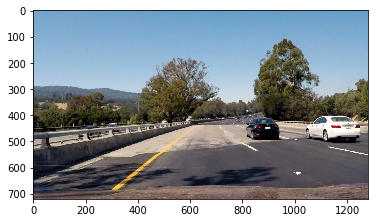

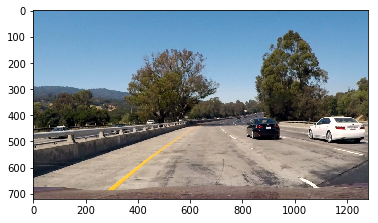

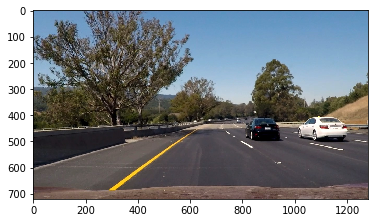

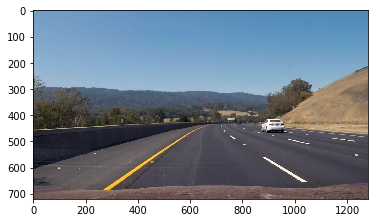

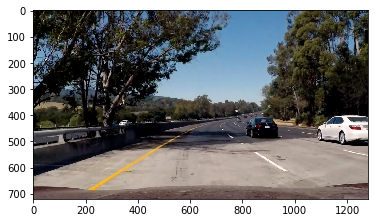

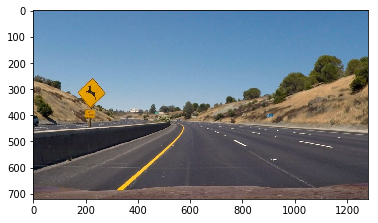

In [2]:
test_image_files = glob.glob("test_images/*.jpg", recursive=True)
test_images = [mpimg.imread(file) for file in test_image_files]
for test_image in test_images:
    plt.figure()
    plt.imshow(test_image)    

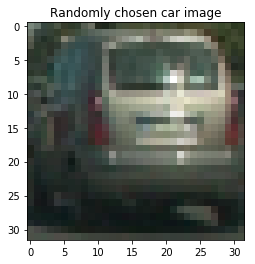

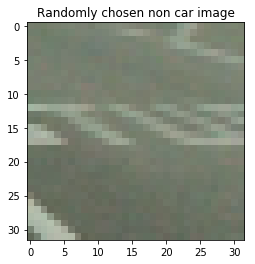

In [3]:
# We train the classifier using downloaded data from GTI and KITTI
training_car_files = glob.glob("./training_images/vehicles/**/*.png", recursive=True)
training_non_car_files = glob.glob("./training_images/non-vehicles/**/*.png", recursive=True)

# training_car_files = training_car_files[:5]
# training_non_car_files = ["./training_images/non-vehicles/Extras/8 (10th copy).png", "./training_images/non-vehicles/Extras/9 (10th copy).png"]

cars     = [cv2.resize(mpimg.imread(file),(32,32) ) for file in training_car_files]
non_cars = [cv2.resize(mpimg.imread(file),(32,32)) for file in training_non_car_files]
random_int = np.random.randint(len(cars))
plt.imshow(cars[random_int])
plt.title("Randomly chosen car image")
plt.figure()
random_int = np.random.randint(len(non_cars))
plt.imshow(non_cars[random_int])
plt.title("Randomly chosen non car image")

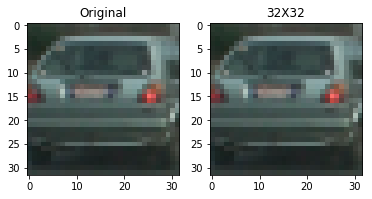

In [4]:
random_int = np.random.randint(len(cars))
plt.subplot(121)
plt.title("Original")
plt.imshow(cars[random_int])
plt.subplot(122)
plt.title("32X32")
plt.imshow(cv2.resize(cars[random_int], (32,32)) )

In [6]:
# Define a function to perform the above processes
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    if color_space == "HSV":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == "LUV":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute color histogram features  
def color_hist(img, nbins=16, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features    

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()

# Set global parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

def extract_features(imgs, color_space='YCrCb', spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

In [7]:
# Draw the windows to verify
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
# define global clf variable
clf = None
X_train = X_test = y_train = y_test = svc = None
car_features = non_car_features = X = X_scaler = scaled_X = y = None

# Set global parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Define helper for updating the extraction, scaling and training
def extract_scale_train(n_samples = 1000, color_space = 'YCrCb',
                        orient = orient,  # HOG orientations
                        pix_per_cell = 8, # HOG pixels per cell
                        cell_per_block = 2, # HOG cells per block
                        hog_channel = hog_channel, # Can be 0, 1, 2, or "ALL"
                        spatial_size = spatial_size, # Spatial binning dimensions
                        hist_bins = 16,    # Number of histogram bins
                        spatial_feat = spatial_feat, # Spatial features on or off
                        hist_feat = hist_feat, # Histogram features on or off
                        hog_feat = True):
    global car_features, non_car_features, X, X_scaler, scaled_X, y
    global X_train, X_test, y_train, y_test, svc, clf
    global cars, non_cars
    
    # shuffle the images used
    shuffle(cars)
    shuffle(non_cars)
    # Extract the features
    car_features     = extract_features(cars[0:min(n_samples, len(cars))],
                                        color_space, spatial_size, hist_bins, orient, 
                                        pix_per_cell, cell_per_block, hog_channel,
                                        spatial_feat, hist_feat, hog_feat)
    # Create a list to append feature vectors to   )
    non_car_features = extract_features(non_cars[0:min(n_samples, len(non_cars))],
                                       color_space, spatial_size, hist_bins, orient, 
                                        pix_per_cell, cell_per_block, hog_channel,
                                        spatial_feat, hist_feat, hog_feat)
    # Prepare the X and y value
    X = np.vstack((car_features, non_car_features)).astype(np.float32)
    # Fit a per column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define y
    y = np.hstack((np.ones(len(car_features)), np.zeros( len(non_car_features) )))
    print("y vector length", len(y))
    print("y shape", y.shape)
    print("X shape", scaled_X.shape)
    
    rand_state = np.random.randint(0,100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.1, random_state=rand_state)
    
    # Create the classifier and train
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    parameters = {'C': [10, 1, 0.1 , 0.01, 0.001]}
    
    clf = GridSearchCV(svc, parameters)
    clf.fit(X_train, y_train)
    print("Test accuracy: ", clf.score(X_test, y_test))
    print("Optimal C: ", clf.best_params_)

In [10]:
extract_scale_train(30000)

y vector length 17764
y shape (17764,)
X shape (17764, 4092)
Test accuracy:  0.979178390546
Optimal C:  {'C': 0.001}


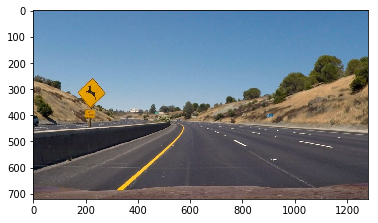

In [12]:

y_start_stop = [400, 700] # Min and max in y to search in slide_window()
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_hot_windows(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
        
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    x_start = 400
    
    img_tosearch = img[ystart:ystop,x_start:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
        
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
        
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 32
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32,32))
                      
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+x_start, ytop_draw+ystart),(xbox_left+x_start+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                hot_windows.append([(xbox_left+x_start, ytop_draw+ystart),(xbox_left+x_start+win_draw,ytop_draw+win_draw+ystart)])
        
    return hot_windows

ystart = 400
ystop = 650
scale = 3
    
    
test_image = test_images[5]
windows = find_hot_windows(test_image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img = draw_boxes(test_image, windows)

plt.imshow(out_img)

In [13]:
# Make a detector tracker to smoothen the tracking
class Detector:
    def __init__(self):
        self.heat = None
        self.box_list_history = []
        self.cum_heat = None
        self.window_len = 15
        self.window_num = 0
    
    def decay_heat(self, heatmap, rate):
        # Decay by rate
        heatmap[heatmap != 0] *= rate
        # Return updated heatmap
        return heatmap# Iterate through list of bboxes
    
    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

            # Return updated heatmap
        return heatmap# Iterate through list of bboxes
    
    def remove_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1

            # Return updated heatmap
        return heatmap# Iterate through list of bboxes
    
    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (25,255,25), 6)
        # Return the image
        return img

    
    def process_image(self, image):    
        draw_img = np.copy(image)
        self.window_num +=1
        
        if self.heat is None:
            self.heat = np.zeros_like(image[:,:,0]).astype(np.float)
            self.cum_heat = self.heat
        
        scale = 4
        box_list = find_hot_windows(image, 400, 700, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        scale = 3
        box_list += find_hot_windows(image, 400, 700, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
        if self.window_num <= self.window_len:
            # Add heat to each box in box list
            self.heat = self.add_heat(np.zeros_like(image[:,:,0]).astype(np.float),box_list)
            # Apply threshold to help remove false positives
            self.heat = self.apply_threshold(self.heat, 3)
            # Update temporal filter information
            self.cum_heat = self.add_heat(self.cum_heat, box_list)
            self.box_list_history.append(box_list)
        else:
            # Update temporal filter information
            self.cum_heat = self.add_heat(self.cum_heat, box_list)
            self.cum_heat = self.remove_heat(self.cum_heat, self.box_list_history[0])
            self.box_list_history.append(box_list)
            self.box_list_history.pop(0)
            self.heat = self.cum_heat / self.window_len
            # Smooth out detection in space
            self.heat = cv2.GaussianBlur(self.heat,(7,7),0)
            # Apply threshold to help remove false positives
            self.heat = self.apply_threshold(self.heat, 1.)
            
            
        # Visualize the heatmap when displaying    
        heatmap = np.clip(self.heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels   = label(heatmap)
        cv2.normalize(heatmap, heatmap, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        heatmap = heatmap.astype(np.uint8)
        
        heatmap  = np.dstack((heatmap, heatmap, heatmap))
                
        draw_img = self.draw_labeled_bboxes(draw_img, labels)                   

        cv2.addWeighted(draw_img, 0.5, heatmap, 0.5, 0.0, draw_img, 16) 
    
        return draw_img
    
    # Use efficient scanner
    def find_cars_efficient(self, image):
        return find_cars(image, 400, 700, 1, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

In [14]:
base_output = 'base_output_with_heat.mp4'


In [15]:
detector = Detector()
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(base_output, audio=False)

[MoviePy] >>>> Building video base_output_with_heat.mp4
[MoviePy] Writing video base_output_with_heat.mp4


100%|█████████▉| 1260/1261 [02:54<00:00,  8.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: base_output_with_heat.mp4 

CPU times: user 4min 40s, sys: 19.8 s, total: 5min
Wall time: 2min 55s


In [16]:
# Show base case results
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(base_output))